## Noções de IA - Trabalho 1 - Regressão Linear na qualidade de vinho
##### Integrantes:
            - Lucas Corrêa Boaventura           - 211038262
            - Alexandre Castanho Sampaio Rocha  - 211027536

### Bibliotecas

In [248]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from d2l import tensorflow as d2l
import random

### Classes


In [249]:
class LinearRegression(d2l.Module): #@save
    """The linear regression model implemented with high-level APIs."""
    """Do d2l"""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        initializer = tf.initializers.RandomNormal(stddev=0.01)
        self.net = tf.keras.layers.Dense(1, kernel_initializer=initializer)

In [250]:
class LinearRegressionData(d2l.DataModule): #@save
    """Data for linear regression."""
    def __init__(self, nInputs,data,num_train=5197, num_val=1300, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.X=data[:,0:nInputs]
        self.y=data[:,nInputs]

@d2l.add_to_class(d2l.DataModule) #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    shuffle_buffer = tensors[0].shape[0] if train else 1
    return tf.data.Dataset.from_tensor_slices(tensors).shuffle(
    buffer_size=shuffle_buffer).batch(self.batch_size)
    
@d2l.add_to_class(LinearRegressionData) #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

### Métodos de Treinamento

In [251]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = tf.keras.losses.MeanSquaredError()
    return fn(y, y_hat)

@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return tf.keras.optimizers.SGD(self.lr)

### Preparando os dados:

In [252]:
data = pd.read_csv('winequalityN.csv')
data = pd.get_dummies(data[data.columns.to_list()[::-1]]) # inverto para a qualidade estar na coluna 1 e adicionar os dummies nas úlimas colunas
data = data[data.columns.to_list()[::-1]] # reinverto para qualidade estar na última coluna
data = data.fillna(data.mean())
data = data.drop('type_red', axis=1) # como só há 2 tipos de vinho, basta uma coluna de True ou False

dataY_aux = data['quality'] - 2 # concertar porque a avaliacao estava de 3 a 9, sendo que o trabalho do pdf pede 1 a 7
#data = data/data.max() # normalizar os dados pelo valor máximo
data = (data - data.mean())/data.std() # normalizar os dados por z-score
data['quality'] = dataY_aux
nInputs = len(data.columns) - 1
data

,type_white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.571323,-0.167146,-0.423531,0.284223,3.206730,-0.315198,0.815503,0.959902,2.102052,-1.359560,-0.545917,-1.418449,4
1,0.571323,-0.707373,-0.241213,0.146512,-0.808074,-0.201012,-0.931035,0.287595,-0.232314,0.508006,-0.277043,-0.831551,4
2,0.571323,0.681783,-0.362758,0.559646,0.305981,-0.172465,-0.029596,-0.331634,0.134515,0.258997,-0.613136,-0.328496,4
3,0.571323,-0.012795,-0.666622,0.008800,0.642300,0.055906,0.928182,1.242978,0.301255,-0.176768,-0.882010,-0.496181,4
4,0.571323,-0.012795,-0.666622,0.008800,0.642300,0.055906,0.928182,1.242978,0.301255,-0.176768,-0.882010,-0.496181,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-1.750055,-0.784548,1.581968,-1.643736,-0.723995,0.969392,0.083083,-1.269324,0.067819,1.441789,0.327925,0.006874,3
6493,-1.750055,-1.016074,1.278104,-1.506025,-0.681955,0.170092,0.477463,-1.145479,0.141185,1.877554,0.000000,0.593772,4
6494,-1.750055,-0.707373,1.035013,-1.299458,-0.660935,0.569742,-0.085936,-1.340094,0.347943,1.255032,1.470642,0.426087,4
6495,-1.750055,-1.016074,1.855445,-1.368314,-0.723995,0.541196,0.083083,-1.269324,0.257903,2.188815,1.201767,-0.244653,3


### Reorganizando os dados para treino e validação numa matriz

In [253]:
train_data, val_data = train_test_split(data, test_size=0.2)
train_data_matrix = tf.convert_to_tensor(train_data, dtype=tf.float32)
val_data_matrix = tf.convert_to_tensor(val_data, dtype=tf.float32)
data_matrix = tf.concat((train_data_matrix, val_data_matrix),axis=0)
val_data_matrix


<tf.Tensor: shape=(1300, 13), dtype=float32, numpy=
array([[ 0.5713226 , -0.5530222 , -0.66662174, ..., -0.68035436,
         1.1806701 ,  5.        ],
       [ 0.5713226 , -0.08997043, -0.48430368, ..., -0.07538673,
        -0.66386604,  3.        ],
       [ 0.5713226 , -0.08997043, -0.3627583 , ..., -1.0164474 ,
        -0.9153937 ,  3.        ],
       ...,
       [-1.7500552 , -0.39867163,  1.3388768 , ...,  0.5295809 ,
        -0.24465327,  3.        ],
       [ 0.5713226 , -0.32149634, -0.3627583 , ...,  1.2689857 ,
         1.012985  ,  3.        ],
       [ 0.5713226 , -1.0160741 , -0.97048515, ..., -0.6131357 ,
         0.6776148 ,  4.        ]], dtype=float32)>

### Efetuando o treinamento

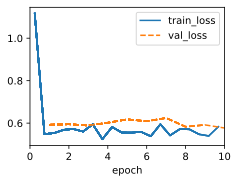

In [254]:
model = d2l.LinearRegression(lr=1e-1)
lr_data = LinearRegressionData(nInputs,data_matrix, num_train=train_data.shape[0], num_val=val_data.shape[0])
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, lr_data)

## Checar a estimativa de erro

### Valor ideal dos pesos

In [255]:
#W_optimal = inv (XT X) XT Y

Xb = tf.concat((data_matrix[:,0:nInputs], tf.ones((6497, 1),dtype=tf.float32)),axis=1)
Y = data_matrix[:,nInputs]
#quad=tf.matmul(tf.transpose(Xb),Xb)
#quad
W_opt = tf.linalg.matvec(tf.linalg.matmul(tf.linalg.inv(tf.matmul(tf.transpose(Xb),Xb)),tf.transpose(Xb)),Y)
#yhat=tf.linalg.matvec(Xb,W)
#yhat[0:5]
W_opt

<tf.Tensor: shape=(13,), dtype=float32, numpy=
array([-0.15544629,  0.10991341, -0.2450017 , -0.00882478,  0.29726493,
       -0.02695634,  0.0875297 , -0.07974647, -0.31187767,  0.07965831,
        0.10782263,  0.2652529 ,  3.8183818 ], dtype=float32)>

### Calculando o erro médio

In [256]:
predictions = tf.transpose(model.call(val_data_matrix[:,:nInputs]))[0]
num_cases = len(predictions)
goal = val_data_matrix[:,nInputs]
trivial = tf.reduce_mean(goal)
kicks = tf.convert_to_tensor([random.randint(1,7) for _ in range(num_cases)], dtype=tf.float32)

mean_error = float(tf.keras.metrics.mean_absolute_error(goal,predictions))
quadratic_error = float(tf.keras.metrics.mean_squared_error(goal,predictions))
mean_error_trivial = float(tf.keras.metrics.mean_absolute_error(goal,trivial))
quadratic_error_trivial = float(tf.keras.metrics.mean_squared_error(goal,trivial))
mean_error_random = float(tf.keras.metrics.mean_absolute_error(goal,kicks))
quadratic_error_random = float(tf.keras.metrics.mean_squared_error(goal,kicks))
pd.DataFrame([
    [mean_error,quadratic_error],
    [mean_error_trivial,quadratic_error_trivial],
    [mean_error_random,quadratic_error_random]
    ],
    columns=['Erro médio absuluto','Erro quadrático médio'],
    index=['Regressão Linear',
           'Preditor Trivial',
           'Preditor Aleatório'])

,Erro médio absuluto,Erro quadrático médio
Regressão Linear,0.583595,0.578165
Preditor Trivial,0.710826,0.799382
Preditor Aleatório,1.896154,5.108461


### Calculando a precisão de acerto

In [257]:
def getAccuracy(target):
    return (len([0 for x in abs(goal - target) if x < 0.5])/num_cases) * 1e2

accuracy = getAccuracy(predictions)
trivial_accuracy = getAccuracy(trivial)
random_accuracy = getAccuracy(kicks)

print(f'Precisão do modelo linar normalizado: {accuracy:.2f}%')
print(f'Precisão do preditor trivial: {trivial_accuracy:.2f}%')
print(f'Precisão do preditor aleatório: {random_accuracy:.2f}%')

Precisão do modelo linar normalizado: 52.15%
Precisão do preditor trivial: 41.85%
Precisão do preditor aleatório: 13.62%


### Correlação entre saída desejada e obtida

In [258]:
correlation = pd.DataFrame()
correlation['Goal'] = goal.numpy()
correlation['Predictions'] = predictions.numpy()
#correlation['Trivial'] = trivial.numpy() # como é constante não há correlação
correlation['Aleatório'] = kicks.numpy()
correlation.corr()

,Goal,Predictions,Aleatório
Goal,1.000000,0.526247,-0.051637
Predictions,0.526247,1.000000,-0.040686
Aleatório,-0.051637,-0.040686,1.000000
